In [1]:
include("multi-pairs-test-utils.jl")

In [11]:
using PyPlot

In [2]:
const gate_data = Dict{Int,NSegSolution}()
for json_file in readdir("data", join=true)
    sol = fromdict(NSegSolution, JSON.parsefile(json_file))
    old_sol = get!(gate_data, sol.nseg, sol)
    if sol !== old_sol
        merge_into!(old_sol, sol)
    end
end

In [4]:
sum([sum([length(s2.solutions) for s2 in s1.solutions]) for (nseg, s1) in gate_data])

526077

In [77]:
function get_area(sol::SolutionInfo, weights)
    return sum(sol.area .* weights)
end
function get_areaδ(sol::SolutionInfo, weights)
    return sum(sol.areaδ .* weights)
end
function get_all_areas(data::NSegSolution, weights)
    total_times = Float64[]
    areas = Float64[]
    for i in 1:25
        for sol in data.solutions[i].solutions
            push!(total_times, sol.total_t)
            push!(areas, get_area(sol, weights))
        end
    end
    return total_times, areas
end
function get_all_areaδs(data::NSegSolution, weights)
    total_times = Float64[]
    areaδs = Float64[]
    for i in 1:25
        for sol in data.solutions[i].solutions
            push!(total_times, sol.total_t)
            push!(areaδs, get_areaδ(sol, weights))
        end
    end
    return total_times, areaδs
end
function get_all_rel_areaδs(data::NSegSolution, weights)
    total_times = Float64[]
    areaδs = Float64[]
    for i in 1:25
        for sol in data.solutions[i].solutions
            push!(total_times, sol.total_t)
            push!(areaδs, get_areaδ(sol, weights) / get_area(sol, weights))
        end
    end
    return total_times, areaδs
end
function get_all_area_rel_areaδs(data::NSegSolution, weights)
    total_times = Float64[]
    areas = Float64[]
    areaδs = Float64[]
    for i in 1:25
        for sol in data.solutions[i].solutions
            push!(total_times, sol.total_t)
            area = get_area(sol, weights)
            areaδ = get_areaδ(sol, weights)
            push!(areas, area)
            push!(areaδs, areaδ / area)
        end
    end
    return total_times, areas, areaδs
end

get_all_area_rel_areaδs (generic function with 1 method)

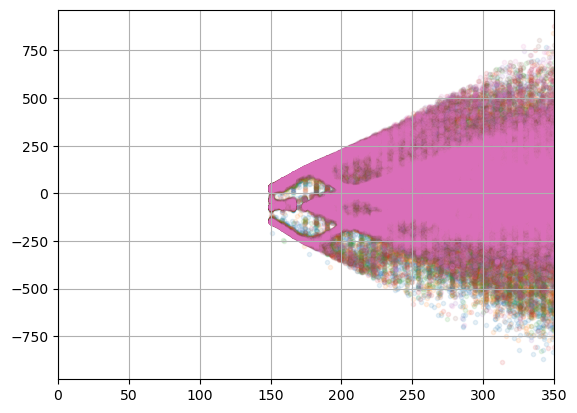

(0.0, 350.0)

In [54]:
weights_flat = (1, 1, 1, 1, 1, 1, 1)
scatter(get_all_areas(gate_data[80], weights_flat)..., marker=".", alpha=0.1, color="C0")
scatter(get_all_areas(gate_data[100], weights_flat)..., marker=".", alpha=0.1, color="C1")
scatter(get_all_areas(gate_data[120], weights_flat)..., marker=".", alpha=0.1, color="C2")
scatter(get_all_areas(gate_data[140], weights_flat)..., marker=".", alpha=0.1, color="C3")
scatter(get_all_areas(gate_data[160], weights_flat)..., marker=".", alpha=0.1, color="C4")
scatter(get_all_areas(gate_data[180], weights_flat)..., marker=".", alpha=0.1, color="C5")
scatter(get_all_areas(gate_data[200], weights_flat)..., marker=".", alpha=0.1, color="C6")
grid()
xlim([0, 350])

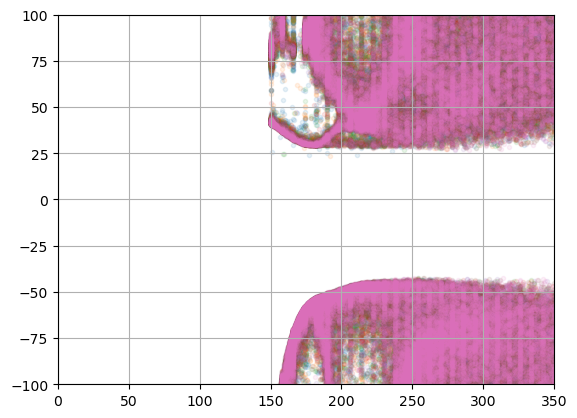

(-100.0, 100.0)

In [55]:
scatter(get_all_rel_areaδs(gate_data[80], weights_flat)..., marker=".", alpha=0.1, color="C0")
scatter(get_all_rel_areaδs(gate_data[100], weights_flat)..., marker=".", alpha=0.1, color="C1")
scatter(get_all_rel_areaδs(gate_data[120], weights_flat)..., marker=".", alpha=0.1, color="C2")
scatter(get_all_rel_areaδs(gate_data[140], weights_flat)..., marker=".", alpha=0.1, color="C3")
scatter(get_all_rel_areaδs(gate_data[160], weights_flat)..., marker=".", alpha=0.1, color="C4")
scatter(get_all_rel_areaδs(gate_data[180], weights_flat)..., marker=".", alpha=0.1, color="C5")
scatter(get_all_rel_areaδs(gate_data[200], weights_flat)..., marker=".", alpha=0.1, color="C6")
grid()
xlim([0, 350])
ylim([-100, 100])

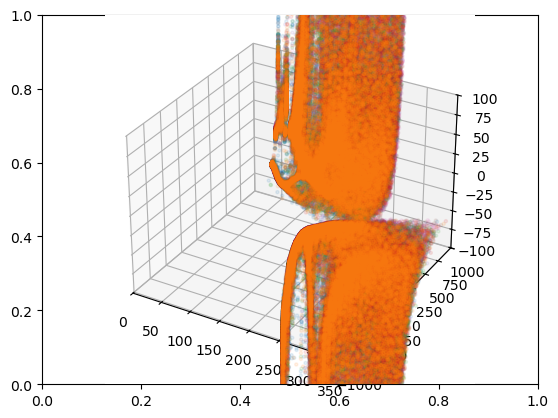

(-100.0, 100.0)

In [79]:
scatter3D(get_all_area_rel_areaδs(gate_data[80], weights_flat)..., marker=".", alpha=0.1, color="C0")
scatter3D(get_all_area_rel_areaδs(gate_data[100], weights_flat)..., marker=".", alpha=0.1, color="C1")
scatter3D(get_all_area_rel_areaδs(gate_data[120], weights_flat)..., marker=".", alpha=0.1, color="C2")
scatter3D(get_all_area_rel_areaδs(gate_data[140], weights_flat)..., marker=".", alpha=0.1, color="C3")
scatter3D(get_all_area_rel_areaδs(gate_data[160], weights_flat)..., marker=".", alpha=0.1, color="C4")
scatter3D(get_all_area_rel_areaδs(gate_data[180], weights_flat)..., marker=".", alpha=0.1, color="C5")
scatter3D(get_all_area_rel_areaδs(gate_data[200], weights_flat)..., marker=".", alpha=0.1, color="C6")
grid()
xlim([0, 350])
zlim([-100, 100])

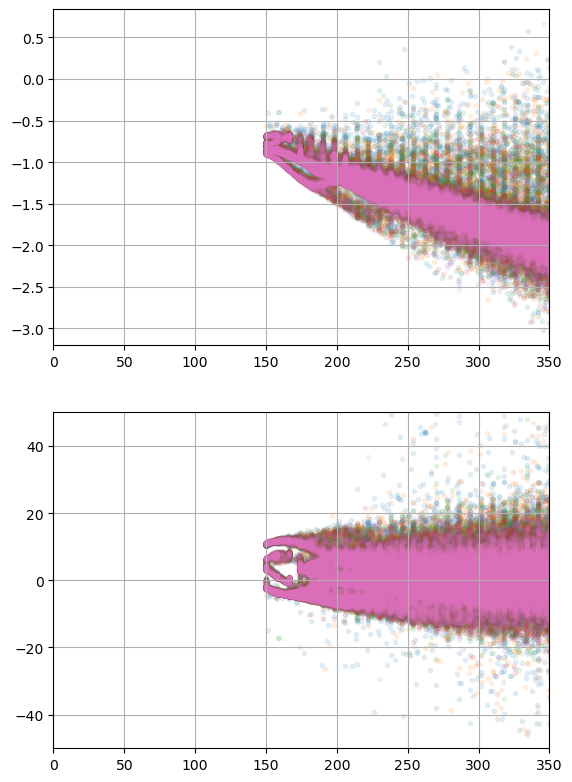

(-50.0, 50.0)

In [75]:
weights = mode_weight!(zeros(7), 2, 3)
figure(figsize=[6.4, 4.8 * 2])
subplot(2, 1, 1)
scatter(get_all_areas(gate_data[80], weights)..., marker=".", alpha=0.1, color="C0")
scatter(get_all_areas(gate_data[100], weights)..., marker=".", alpha=0.1, color="C1")
scatter(get_all_areas(gate_data[120], weights)..., marker=".", alpha=0.1, color="C2")
scatter(get_all_areas(gate_data[140], weights)..., marker=".", alpha=0.1, color="C3")
scatter(get_all_areas(gate_data[160], weights)..., marker=".", alpha=0.1, color="C4")
scatter(get_all_areas(gate_data[180], weights)..., marker=".", alpha=0.1, color="C5")
scatter(get_all_areas(gate_data[200], weights)..., marker=".", alpha=0.1, color="C6")
grid()
xlim([0, 350])

subplot(2, 1, 2)
scatter(get_all_rel_areaδs(gate_data[80], weights)..., marker=".", alpha=0.1, color="C0")
scatter(get_all_rel_areaδs(gate_data[100], weights)..., marker=".", alpha=0.1, color="C1")
scatter(get_all_rel_areaδs(gate_data[120], weights)..., marker=".", alpha=0.1, color="C2")
scatter(get_all_rel_areaδs(gate_data[140], weights)..., marker=".", alpha=0.1, color="C3")
scatter(get_all_rel_areaδs(gate_data[160], weights)..., marker=".", alpha=0.1, color="C4")
scatter(get_all_rel_areaδs(gate_data[180], weights)..., marker=".", alpha=0.1, color="C5")
scatter(get_all_rel_areaδs(gate_data[200], weights)..., marker=".", alpha=0.1, color="C6")
grid()
xlim([0, 350])
ylim([-50, 50])